04/22 to 
ML 
1. tackle the problem of units (scale MSE in terms of wavelenth)
2. Correct the MSE computation.
3. Save eps image and solve ylim and legend problem.

下一步：
多尝试不同noise_std
尝试不同prior_sigma大小

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.random import randn 
import pandas as pd
import seaborn as sns
import matplotlib.ticker as mtick
import time
from scipy.optimize import fmin_l_bfgs_b
from scipy.optimize import minimize
import pandas as pd
from sklearn.linear_model import OrthogonalMatchingPursuit
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import math
import time
np.random.seed(28)

#plotting setting
size=10;f=10
figsize=(8,6)

from ML_estimator import *
from Evaluation import *
from Basic import *

# EXP 3 synthetic priors （Previous name: EXP 4）

In [2]:
import random
def Synthetic_prior(target,num_sample,prior_sigma):
    K=len(target)
    prior_means=np.zeros((K,num_sample,2))
    for i in range(K):
        for j in range(num_sample):
            prior_means[i,j,:]=np.random.multivariate_normal(mean=target[i],cov=prior_sigma**2*np.eye(2)).reshape(2)
    return prior_means


def experiment4(N,lmb,d,targets,noise_std,ml_resol,prior_means,prior_sigma,flag_plot):
    # Array
    arr_dim=d*(N-1) # dimension of the array
    arr=array(N,arr_dim,0) # array elements location
    R_near=near_field_Boundary(lmb,arr_dim)
    arr_center=0.5*arr_dim
    time_ML=0
    time_ML_prior=0
    #Prepare arrays for results
    num_sam=5
    true_targets=np.empty([len(targets),num_sam,2])
    ML_targets=np.empty([len(targets),num_sam,2])
    ML_targets_prior=np.empty([len(targets),num_sam,2])

    #begin experiment
    for i in range (len(targets)):
        if(i%10==0):
            print(i)
        
        for j in range(num_sam):
            true_targets[i,j]=targets[i]
            # phase measurements
            phase_obs=np.zeros(N)
            # phi_0=np.random.uniform(low=0,high=2*np.pi)#phase shift (offset, unknown constant)
            phi_0=1
#             print(f'phase shift is {phi_0}rad')

            dist=np.array([np.linalg.norm(arr[n]-true_targets[i,j]) for n in range(N)])#distance between the elements and target
            phase_obs=(4*np.pi/lmb*dist+phi_0+randn(N)*noise_std)%(2*np.pi)
            phase_shift=(4*np.pi/lmb*dist+phi_0)%(2*np.pi)
            phase_true=(4*np.pi/lmb*dist)%(2*np.pi)
            phase_true_unwrap=(4*np.pi/lmb*dist)

            if(flag_plot==1):
            #plot the phases
                plt.figure(figsize=(4,4))
                plt.scatter(range(1,N+1),phase_obs,color='red',s=size)
                plt.scatter(range(1,N+1),phase_shift,color='purple',s=size)
                plt.scatter(range(1,N+1),phase_true,color='green',s=size)
                plt.scatter(range(1,N+1),phase_true_unwrap,color='blue',s=size)
                plt.legend(['obs','shift','true','true unwrap'])
                plt.title('Target and array')
                plt.xlabel('x axis [Anetenna]')
                plt.ylabel('y axis [rad]')
            
            #search space
            xrange=np.array([arr_center-R_near,arr_center+R_near])
            yrange=np.array([0,R_near])
            
            prior_mean=prior_means[i,j]
            xrange_p=np.array([prior_mean[0]-3*prior_sigma,prior_mean[0]+3*prior_sigma])
            yrange_p=np.array([prior_mean[1]-3*prior_sigma,prior_mean[1]+3*prior_sigma])
            
            #ML
            T1=time.perf_counter()
            ml=ML()
            num_grid,Loc_MLgrid=ml.ML_grid(xrange,yrange,phase_obs,arr,lmb,resolution=ml_resol,flag_prior=False,flag_plot=False)
            num=num_grid[0]*num_grid[1]
            T2=time.perf_counter()
            time_ML+=(T2-T1)
        #     ml.plotting(size,f,targets,Loc_MLgrid,xrange,yrange)
            ML_targets[i,j]=Loc_MLgrid.reshape(2)        
            
            
            #ML + prior bounding search space
            T1=time.perf_counter()
            ml=ML()
            num_grid,Loc_MLgrid_prior=ml.ML_grid(xrange_p,yrange_p,phase_obs,arr,lmb,resolution=ml_resol,flag_prior=False,flag_plot=False)
            num_prior=num_grid[0]*num_grid[1]
            T2=time.perf_counter()
            time_ML_prior+=(T2-T1)
        #     ml.plotting(size,f,targets,Loc_MLgrid,xrange,yrange)
            ML_targets_prior[i,j]=Loc_MLgrid_prior.reshape(2)  
            
            
    print(f'ML processing time per iteration:{time_ML/(len(targets)*num_sam)}s.')
    print(f'ML + prior processing time per iteration:{time_ML_prior/(len(targets)*num_sam)}s.')
    return true_targets,ML_targets,ML_targets_prior,num,num_prior


In [3]:
#main 
N=10 # number of elements
lmb=2e-3 # wavelength of the signal
d=0.25*lmb # distance between 2 adjacent elements


arr_dim=d*(N-1) # dimension of the array
arr=array(N,arr_dim,0) # array elements location
R_near=near_field_Boundary(lmb,arr_dim)
arr_center=0.5*arr_dim

# generating targets
N_target=100
# targets = sample_in_half_circle(R_near,N_target)+np.array([arr_center,0])
# # print(f"True target:{targets}")
# np.savetxt('targets.txt',targets)
targets=np.loadtxt('targets.txt')
# print(targets)


(100, 5, 2)
0
ML processing time per iteration:0.025671030004741625s.
ML + prior processing time per iteration:0.00131239999900572s.
noise_std:0.1,ML1 resolution:0.5wavelength
ML_mean_Squared_loss: 2.413e-06
861 49


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


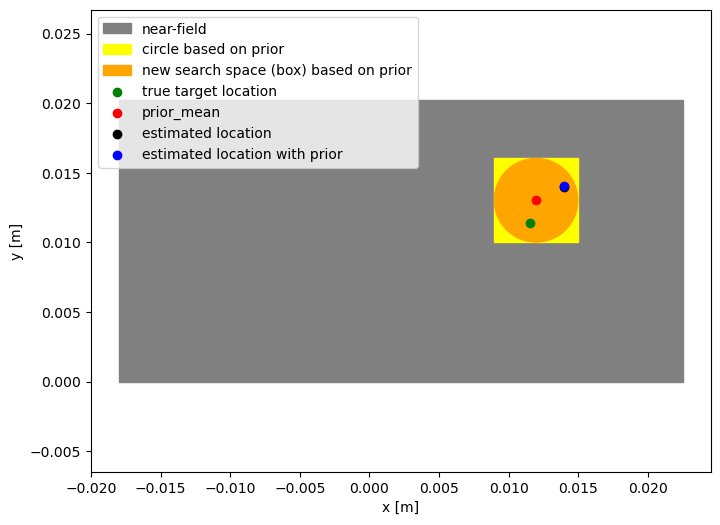

In [4]:
#generate synthetic priors
prior_sigma=1e-3
prior_means=Synthetic_prior(targets,5,prior_sigma)
print(prior_means.shape)

#illustrations

ML_MSE_mean=np.empty([3,3])

noise_std=0.1
ml_resol=0.5*lmb
flag_plot=0



fig=plt.figure(figsize=figsize)
ax=fig.add_subplot(1,1,1)


true_targets,ML_targets,ML_targets_prior,num,num_prior=experiment4(N,lmb,d,targets[0:2],noise_std,ml_resol,prior_means[0:2],prior_sigma,flag_plot)
ML_MSE_mean[0,0],_=evaluate(true_targets,ML_targets_prior)
print(f'noise_std:{noise_std},ML1 resolution:{ml_resol/lmb}wavelength')
print(f'ML_mean_Squared_loss: {ML_MSE_mean[0,0]:.4}')
print(num,num_prior)




near_field_square=plt.Rectangle(xy=(arr_center-R_near,0),height=R_near,width=2*R_near,color='gray')
square_1=plt.Rectangle(xy=(prior_means[0,0,0]-3*prior_sigma,prior_means[0,0,1]-3*prior_sigma),height=prior_sigma*6,width=6*prior_sigma,color='yellow')
circle_1=plt.Circle(xy=(prior_means[0,0,0],prior_means[0,0,1]),radius=3*prior_sigma,color='orange')

ax.add_patch(near_field_square)
ax.add_patch(square_1)
ax.add_patch(circle_1)

plt.scatter(targets[0,0],targets[0,1],c='green')
plt.scatter(prior_means[0,0,0],prior_means[0,0,1],c='r')
plt.scatter(ML_targets[0,0,0],ML_targets[0,0,1],c='black')
plt.scatter(ML_targets_prior[0,0,0],ML_targets_prior[0,0,1],c='blue')
plt.axis('equal')
plt.xlabel('x [m]')
plt.ylabel('y [m]')
plt.legend(['near-field','circle based on prior','new search space (box) based on prior','true target location','prior_mean','estimated location','estimated location with prior'])
plt.savefig('C:/Users/73160/OneDrive/项目/project/Weekly reports/Sp_10/Illustration_prior.png')
plt.savefig('C:/Users/73160/OneDrive/项目/project/Weekly reports/Sp_10/Illustration_prior.eps',format='eps')

In [6]:
def Noise_scaledB_to_linear(noise_scale_dB,lmb):
    noise_std_linear=np.empty(len(noise_scale_dB))
    for i in range(len(noise_scale_dB)):
        noise_std_linear[i] = math.pow(10,(-noise_scale_dB[i]/20))/lmb
    return noise_std_linear

In [7]:
# noise_scale_dB=np.array([75,90,105])
# noise_std=Noise_scaledB_to_linear(noise_scale_dB,lmb)
# noise_std_scale=noise_std*lmb
# noise_scale_dB = todB(1/((noise_std_scale)**2))
# print(noise_scale_dB)

In [8]:
#generate synthetic priors
prior_sigma=1e-3
print(f'prior_sigma = {prior_sigma/lmb} wavelength')
prior_means=Synthetic_prior(targets,5,prior_sigma)
print(prior_means.shape)

#EXP4
noise_scale_dB=np.array([60,75,90,105])
noise_std=Noise_scaledB_to_linear(noise_scale_dB,lmb)
print(noise_std)
ml_resol=[0.5*lmb,0.25*lmb,0.125*lmb]
ML_MSE_mean=np.empty([len(noise_std),len(ml_resol),2])
ML_MSE_std=np.empty([len(noise_std),len(ml_resol),2])
flag_plot=0
for i in range(len(noise_std)):
    for j in range(len(ml_resol)):
        true_targets,ML_targets,ML_targets_prior,num,num_prior=experiment4(N,lmb,d,targets,noise_std[i],ml_resol[j],prior_means,prior_sigma,flag_plot)
        ML_MSE_mean[i,j,0],ML_MSE_std[i,j,0]=evaluate(true_targets,ML_targets)
        ML_MSE_mean[i,j,1],ML_MSE_std[i,j,1]=evaluate(true_targets,ML_targets_prior)
        print(f'noise_std:{noise_std[i]},ML1 resolution:{ml_resol[j]/lmb}wavelength')
        print(f'ML_mean_Squared_loss: {ML_MSE_mean[i,j,0]:.4}')
        print(f'ML_mean_Squared_loss_prior: {ML_MSE_mean[i,j,1]:.4}')
        print(f'number of grids: {num},{num_prior}')

prior_sigma = 0.5 wavelength
(100, 5, 2)
[0.5        0.08891397 0.01581139 0.00281171]
0
10
20
30
40
50
60
70
80
90
ML processing time per iteration:0.0352059397988487s.
ML + prior processing time per iteration:0.0018856175997061654s.
noise_std:0.5,ML1 resolution:0.5wavelength
ML_mean_Squared_loss: 3.512e-05
ML_mean_Squared_loss_prior: 2.971e-06
number of grids: 861,42
0
10
20
30
40
50
60
70
80
90
ML processing time per iteration:0.12714431439898907s.
ML + prior processing time per iteration:0.006175476001226343s.
noise_std:0.5,ML1 resolution:0.25wavelength
ML_mean_Squared_loss: 3.407e-05
ML_mean_Squared_loss_prior: 3.54e-06
number of grids: 3362,156
0
10
20
30
40
50
60
70
80
90
ML processing time per iteration:0.5183356744000921s.
ML + prior processing time per iteration:0.023832947999821046s.
noise_std:0.5,ML1 resolution:0.125wavelength
ML_mean_Squared_loss: 3.47e-05
ML_mean_Squared_loss_prior: 4.075e-06
number of grids: 13366,600
0
10
20
30
40
50
60
70
80
90
ML processing time per i

In [9]:
ML_MSE_mean_scale=ML_MSE_mean/(lmb**2)  #scale according to wavelenth (not sure)
ML_MSE_mean_dB=todB(ML_MSE_mean_scale)
ML_MSE_std_scale=ML_MSE_std/(lmb**2)
ML_MSE_std_dB=todB(ML_MSE_mean_scale+ML_MSE_std_scale)-ML_MSE_mean_dB

np.savetxt('C:/Users/73160/OneDrive/项目/project/Weekly reports/Sp_10/Exp4_result_ML_MSE_mean_dB.txt',ML_MSE_mean_dB[:,:,0],fmt='%.03e')
np.savetxt('C:/Users/73160/OneDrive/项目/project/Weekly reports/Sp_10/Exp4_result_ML_MSE_std_dB.txt',ML_MSE_std_dB[:,:,0],fmt='%.03e')
np.savetxt('C:/Users/73160/OneDrive/项目/project/Weekly reports/Sp_10/Exp4_result_ML_MSE_mean_dB_prior.txt',ML_MSE_mean_dB[:,:,1],fmt='%.03e')
np.savetxt('C:/Users/73160/OneDrive/项目/project/Weekly reports/Sp_10/Exp4_result_ML_MSE_std_dB_prior.txt',ML_MSE_std_dB[:,:,1],fmt='%.03e')
# ML_MSE_mean_dB =np.empty([len(noise_std),len(ml_resol),2])
# ML_MSE_mean_dB[:,:,0]=np.loadtxt('C:/Users/73160/OneDrive/项目/project/Weekly reports/Sp_10/Exp4_result_ML_MSE_mean_dB.txt')
# ML_MSE_mean_dB[:,:,1]=np.loadtxt('C:/Users/73160/OneDrive/项目/project/Weekly reports/Sp_10/Exp4_result_ML_MSE_mean_dB_prior.txt')


In [10]:
def plot_result_EXP4(noise_scale_dB,ML_MSE_mean_dB):
    plt.figure(figsize=figsize)
    color=['r','b','g','black']
    for j in range(len(ml_resol)):
        plt.plot(noise_scale_dB,ML_MSE_mean_dB[:,j,0],'+-',label=r'ML $s_{grid}=$'rf'{ml_resol[j]/lmb}$\lambda$',c=color[j])
        plt.plot(noise_scale_dB,ML_MSE_mean_dB[:,j,1],'*--',label=r'ML+prior $s_{grid}=$'rf'{ml_resol[j]/lmb}$\lambda$',c=color[j])
   
    plt.legend(bbox_to_anchor=(1, 1.15),ncol=3)

    plt.xlabel(r'$σ^{-2}$ [dB]')
    plt.ylabel(r'MSE $\hat{u}$ [dB]')
    plt.grid()
    
    plt.savefig('C:/Users/73160/OneDrive/项目/project/Weekly reports/Sp_10/Exp4_MSE_Result.png')
    plt.savefig('C:/Users/73160/OneDrive/项目/project/Weekly reports/Sp_10/Exp4_MSE_Result.eps',format='eps') 

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


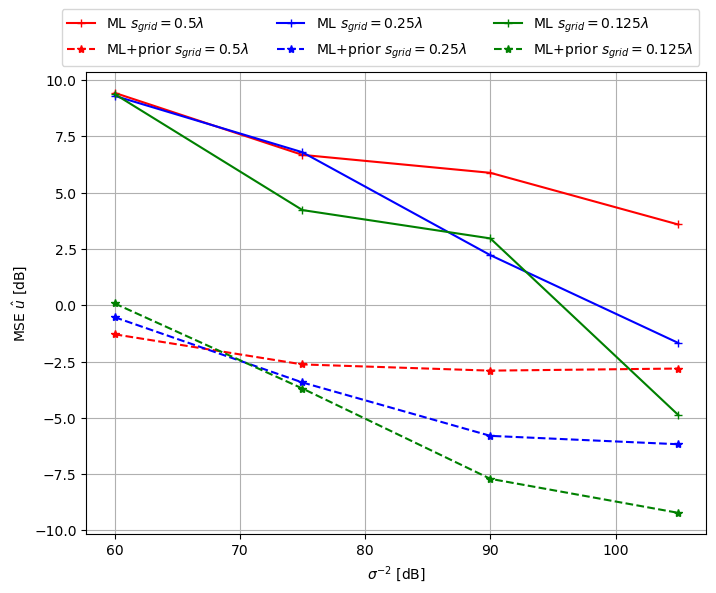

In [11]:
plot_result_EXP4(noise_scale_dB, ML_MSE_mean_dB)